Importando Librerias

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0'

In [4]:
import cv2
import imageio
import matplotlib.pyplot as plt, zipfile
import numpy as np
import os
import PIL
import xml.etree.ElementTree as ET
from tqdm import tqdm
import glob
import re
from tensorflow.keras import layers
import time
from PIL import Image
from IPython import display
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


Analizando Dataset

In [5]:
imageneslista=glob.glob('../input/stanford-dogs-dataset/images/Images/*')
imageness=[]
for t in imageneslista:
    imageness+=glob.glob(t+"/*")
print(f"numero de imagenes : {len(imageness)}")

razas = glob.glob('../input/stanford-dogs-dataset/annotations/Annotation/*')
annotation=[]
for i in razas:
    annotation+=glob.glob(i+"/*")
print(f"numero de anotaciones : {len(annotation)}")

breed_map={}
for annot in annotation:
    razas=annot.split("/")[-2]
    index=razas.split("-")[0]
    breed_map.setdefault(index,razas)
    
print(f"numero de razas : {len(breed_map)}")

numero de imagenes : 20580
numero de anotaciones : 20580
numero de razas : 120


In [6]:
breed_list = os.listdir('../input/stanford-dogs-dataset/annotations/Annotation')
print(breed_list)

['n02104365-schipperke', 'n02096294-Australian_terrier', 'n02085782-Japanese_spaniel', 'n02091467-Norwegian_elkhound', 'n02093859-Kerry_blue_terrier', 'n02112350-keeshond', 'n02097209-standard_schnauzer', 'n02113186-Cardigan', 'n02094258-Norwich_terrier', 'n02085620-Chihuahua', 'n02088094-Afghan_hound', 'n02110185-Siberian_husky', 'n02106662-German_shepherd', 'n02112706-Brabancon_griffon', 'n02097130-giant_schnauzer', 'n02095314-wire-haired_fox_terrier', 'n02091032-Italian_greyhound', 'n02107142-Doberman', 'n02105412-kelpie', 'n02113978-Mexican_hairless', 'n02099849-Chesapeake_Bay_retriever', 'n02101388-Brittany_spaniel', 'n02115913-dhole', 'n02101556-clumber', 'n02113624-toy_poodle', 'n02100236-German_short-haired_pointer', 'n02108915-French_bulldog', 'n02101006-Gordon_setter', 'n02089078-black-and-tan_coonhound', 'n02107574-Greater_Swiss_Mountain_dog', 'n02106166-Border_collie', 'n02116738-African_hunting_dog', 'n02104029-kuvasz', 'n02106382-Bouvier_des_Flandres', 'n02108551-Tibetan_

Mostrando algunas imagenes de perros haciendo uso del bounding box

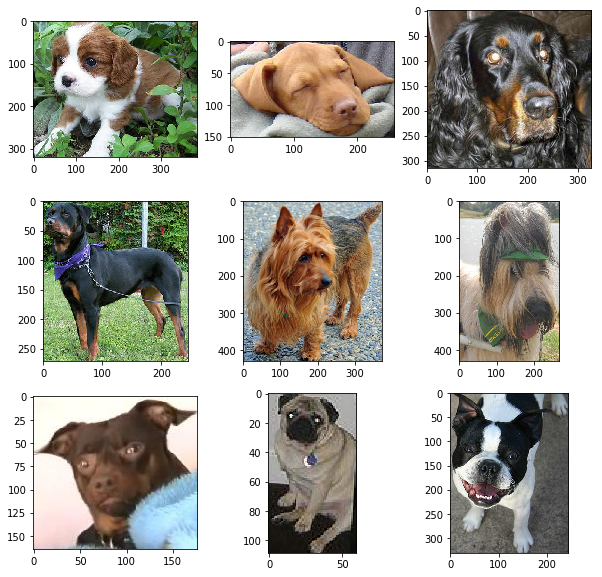

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # showing 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/' + breed)) # random image 
    img = Image.open('../input/stanford-dogs-dataset/images/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() # idk what's it but it's from documentation
    objects = root.findall('object') # finding all dogs. An array
    plt.imshow(img) # displays photo
    for o in objects:
        bndbox = o.find('bndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        #plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        #plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) # printing breed
    imagen1=img.crop((xmin, ymin, xmax, ymax))
    plt.imshow(imagen1)
    #plt.imshow(img)


In [8]:
def cropimagen(imagen):
    mm = re.search('input/stanford-dogs-dataset/images/Images/(.+?).jpg', imagen)
    if mm:
        perro = mm.group(1)
    img = Image.open('../input/stanford-dogs-dataset/images/Images/' + perro + '.jpg')
    tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/' + perro) # init parser for file given
    root = tree.getroot() # idk what's it but it's from documentation
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    imagen1=img.crop((xmin, ymin, xmax, ymax))  
    return imagen1
    

Creando un arreglo de imagenes 64x64

In [9]:
width = 64
height = 64
imagenescortadas=[]
myarray=np.zeros((20580,64,64,3))


for i,image in enumerate(imageness):
    img=cropimagen(image).resize((width, height), Image.NEAREST)
    #plt.imshow(img)
    imgar=(img_to_array(img))
    if imgar.shape == (64,64,3):
      myarray[i,:,:,:]=imgar

    #print(i)
    
    #imagenescortadas.append(imgar[:,:,0])
    #imagenescortadas.append(imgar[:,:,1])
    #imagenescortadas.append(imgar[:,:,2])
    #if i==1:
        #break
    

    
#myarray = np.asarray(imagenescortadas)
print(myarray.shape)
del imagenescortadas

(20580, 64, 64, 3)


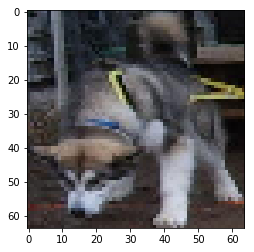

In [10]:
plt.imshow(myarray[20579, :,:,:]/255)

In [11]:
a = ((myarray- 127.5)/127.5)

In [12]:
a = tf.cast (a, 'float32')

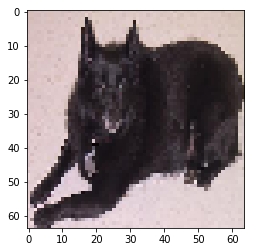

In [13]:
plt.imshow(((a[67]+1.)/2.))

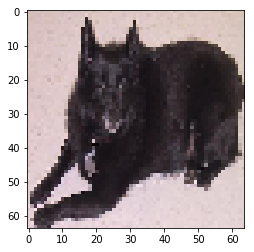

In [14]:
plt.imshow(myarray[67]/255)

In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [16]:
EPOCHS = 600
noise_dim = 100
num_examples_to_generate = 9
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices(a).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Modelo de generador

In [18]:
def make_generator_model():
    model = tf.keras.Sequential(
        [
          
            tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
         
            tf.keras.layers.BatchNormalization(),
           
            tf.keras.layers.LeakyReLU(),
           
            tf.keras.layers.Reshape((8, 8, 512)),
            
       
            tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Dense(3,activation='tanh', use_bias=False,\
                kernel_initializer=WEIGHT_INIT)
        ]
    )
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

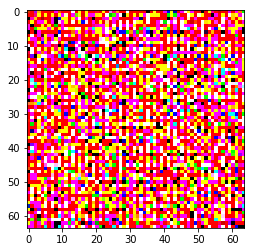

In [19]:
generator = make_generator_model()
print(generator.summary())
'''
noise=tf.random.uniform(
    [1, 100],
    minval=0,
    maxval=1,
    dtype=tf.dtypes.float32)
print(noise.shape)
'''
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image=(generated_image)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :,:])

Modelo de discriminador

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[width,height,3],\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            
            tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            
            tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

In [21]:
discriminator = make_discriminator_model()
print(discriminator.summary())
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

In [22]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.5


def noisy_labels(y, p_flip):

	n_select = int(p_flip * y.shape[0].value)
	
	flip_ix = choice([i for i in range(y.shape[0].value)], size=n_select)

	y[flip_ix] = 1 - y[flip_ix]
	return y

In [23]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

Funciones loss

In [24]:
def discriminator_loss(real_output, fake_output):
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))

    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    return cross_entropy(fake_output_smooth, fake_output)

In [26]:
generator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [29]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    #a,b=train_step(image_batch)
    print(train_step(image_batch))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [30]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  if epoch%25==0:
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,5))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        #plt.imshow(((predictions[i, :, :, :]+1)*127.5)/255)
        plt.imshow(((predictions[i, :, :, :]+1.)/2.))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Entrenar el modelo

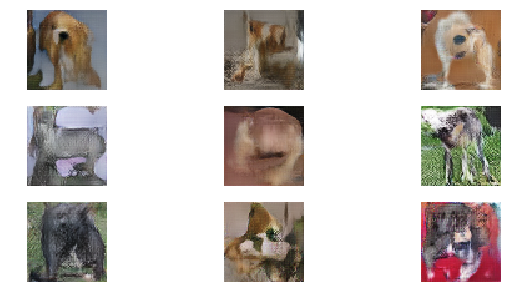

CPU times: user 1h 17min 56s, sys: 17min 27s, total: 1h 35min 24s
Wall time: 4h 32min 48s


In [31]:
%%time
train(train_dataset, EPOCHS)

In [32]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

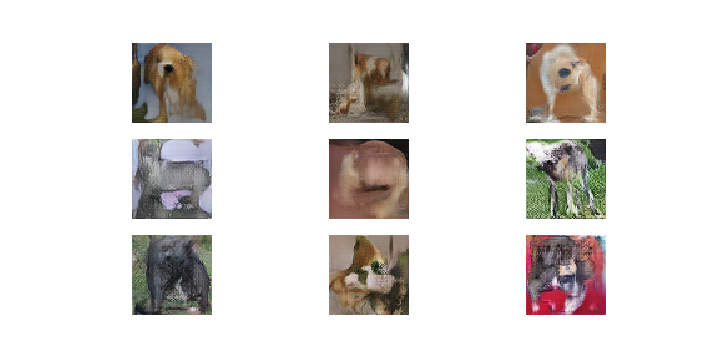

In [33]:
display_image(EPOCHS)

In [34]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [35]:
%%time
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')

for k in range(1000):
    generated_image = generator(tf.random.normal([1, noise_dim]), training=False)
    f = str(k)+'.png'
    img = ((generated_image[0,:,:,:]+1.)/2.).numpy()
    tf.keras.preprocessing.image.save_img(
        f,
        img,
        scale=True
    )
    z.write(f); os.remove(f)
z.close()

CPU times: user 17 s, sys: 1.54 s, total: 18.6 s
Wall time: 16.1 s
